In [1]:
from sample_bot import *
import shutil
import argparse
from datetime import datetime

import socketio
import eventlet
import eventlet.wsgi
from flask import Flask

import math
from queue import Queue

import tensorflow as tf

import tensorflow.contrib.slim as slim
from random import random, choice

from time import sleep
from random import randint, random, sample
import pyautogui
from IPython import display
import heapq

import traceback
import matplotlib.pyplot as plt
%matplotlib inline

In [2]:
batch_size = 128
max_size = batch_size*10
t_max = 100
reload_window = batch_size
reward_decay = 0.99
last_state = None
last_action = None
last_reward = None
learning_rate = 0.001
mu = 0.999
crashing_reward = -1

In [3]:
# 11 possible steering angles, 0 and 5 uniformly selected angle from 0~pi and 0~-1*pi
#ANGLES = [-3.141592653589793, -2.5132741228718345, -1.8849555921538759, -1.2566370614359172, -0.6283185307179586, 0, 0.6283185307179586, 1.2566370614359172, 1.8849555921538759, 2.5132741228718345, 3.141592653589793]
ANGLES = [-0.349065850398866, -0.3316125578789227, -0.31415926535897937, -0.29670597283903605, -0.2792526803190927, -0.2617993877991494, -0.24434609527920612, -0.22689280275926282, -0.20943951023931953, -0.19198621771937624, -0.17453292519943295, -0.15707963267948966, -0.13962634015954636, -0.12217304763960306, -0.10471975511965977, -0.08726646259971647, -0.06981317007977318, -0.05235987755982989, -0.03490658503988659, -0.017453292519943295, 0, 0.017453292519943295, 0.03490658503988659, 0.05235987755982989, 0.06981317007977318, 0.08726646259971647, 0.10471975511965977, 0.12217304763960306, 0.13962634015954636, 0.15707963267948966, 0.17453292519943295, 0.19198621771937624, 0.20943951023931953, 0.22689280275926282, 0.24434609527920612, 0.2617993877991494, 0.2792526803190927, 0.29670597283903605, 0.31415926535897937, 0.3316125578789227, 0.349065850398866]
#ANGLES = [0.0]
# 3 possible throttle options
THROTTLES = [0.2, 0.4, 0.6, 0.8, 1.0]
#THROTTLES = [0.0, 0.1]
ACTIONS = [(angle, throttle) for angle in ANGLES for throttle in THROTTLES] #33 actions

In [4]:
def send_control(steering_angle, throttle):
    sio.emit(
        "steer",
        data={
            'steering_angle': str(steering_angle),
            'throttle': str(throttle)
        },  
        skip_sid=True)
    
def calculate_avg(series):
    return [np.mean(serie) for serie in series]

def plot(series):
    colors = ['r', 'y', 'g', 'b', 'p']
    to_plot = []
    for i in range(len(series)):
        to_plot += [series[i], colors[i]]
        
    plt.plot(*to_plot)
    display.display(plt.gcf())
    display.clear_output(wait=True)
#plot([[x for x in range(10)], [x+1 for x in range(10)]])

In [5]:
class Action:
    def __init__(self, action_idx):
        self.action_idx = action_idx
        self.steering_angle = ACTIONS[action_idx][0]
        self.throttle = ACTIONS[action_idx][1]
        
    def __repr__(self):
        return str({'throttle': self.throttle, 'angle': self.steering_angle})

class Transaction:
    columns = ['state', 'action', 'reward', 'next_state', 'advantage']
    
    def __init__(self, item):
        self.item = dict(zip(Transaction.columns, item))
    
    def  __lt__(self, other):
        #sort by time
        return self.item['id'] < other.item['id']
        #sort by gained label
        #return self.item['label'] < other.item['label']
    
    def __repr__(self):
        return str(self.item)
        
    def __getitem__(self, key):
        return self.item[key]
    
    def __setitem__(self, key, value):
        self.item[key] = value

class Memory:
    def __init__(self, max_size):
        MAX_TRANSACTION = Transaction(Transaction.columns)
        MAX_TRANSACTION.item['id'] = -1
        self.d = []
        self.id = 0
        self.max_size = max_size

    def insert(self, item):
        self.id += 1
        item['id'] = self.id
        #print(self.d)

        if len(self.d) == self.max_size:
            heapq.heapreplace(self.d, item)
        else:
            heapq.heappush(self.d, item)

    def batch(self, n):
        if len(self.d) > n:
            batch = np.array(sample(self.d, n))
            return batch
        else:
            return np.array(self.d)

In [6]:
# policy & value network only different at last layer
# common part is cnn1-cnn1-fc
def build_network():
    with tf.variable_scope('Action-Critic-Network-Common', reuse=tf.AUTO_REUSE):
        #inputs = tf.placeholder(shape=(None, 108, 320, 3), dtype=tf.float32) # track image
        inputs = tf.placeholder(shape=(None, 240, 320, 3), dtype=tf.float32, name='input_img') # track image
        layer_1 = slim.conv2d(inputs=inputs, num_outputs=16, kernel_size=(8, 8), stride=(8, 8), padding='VALID', activation_fn=tf.nn.elu)
        layer_2 = slim.conv2d(inputs=layer_1, num_outputs=32, kernel_size=(4, 4), stride=(4, 4), padding='VALID', activation_fn=tf.nn.elu)
        fc_layer = tf.layers.dense(inputs=slim.flatten(layer_2), units=256, activation=tf.nn.relu)
    return inputs, fc_layer

In [7]:
class ACNetwork:
    def __init__(self):
        self.action_size = len(ACTIONS)
        self.output_size = 1
        self.model_folder = './model/actor_critic_network'
        
        self.advantage = tf.placeholder(shape=(None, self.action_size), dtype=tf.float32, name='advantage')
        self.rewards = tf.placeholder(shape=(None), dtype=tf.float32, name='rewards')
        
        inputs, output = build_network()
        self.inputs = inputs
        self.common = output
    
        self.policy_metrics = {}
        self.policy_metrics['loss'] = []
        
        self.value_metrics = {}
        self.value_metrics['loss'] = []
        
        with tf.variable_scope('policy-network'):
            self.actions_values = tf.layers.dense(output, units=self.action_size, activation=tf.nn.softmax) # batch_size, action_size
            self.best_action = tf.argmax(self.actions_values, axis=1)

            self.policy_loss = tf.reduce_sum(tf.log(self.actions_values) * self.advantage)*-1
            
        with tf.variable_scope('value-network'):
            self.state_value = tf.layers.dense(output, units=self.output_size)
            self.value_loss = tf.reduce_sum(tf.square(self.state_value - self.rewards))
        
        self.loss = self.policy_loss + self.value_loss
        self.train_op = tf.train.AdamOptimizer(learning_rate=learning_rate).minimize(self.loss)

        self.sess = tf.Session()
        self.target_sess = tf.Session()
        
        self.sess.run(tf.global_variables_initializer())
        self.target_sess.run(tf.global_variables_initializer())

        self.saver = tf.train.Saver()
    
    def get_action(self, state):
        best_action = self.target_sess.run(self.best_action, feed_dict={self.inputs: [state]})[0]
        return best_action
        
    def get_state_values(self, states):
        state_values = self.target_sess.run(self.state_value, feed_dict={self.inputs: states})
        return state_values
    
    def get_state_value(self, state):
        return self.get_state_values([state])[0]
    
    def get_advantages(self, batch):
        advantages = []
        for transaction in batch:
            # unselected actions get 0 advantage, selected action get reward - current_state_value advantage
            advantage = [0]*self.action_size
            advantage[transaction['action']] = transaction['advantage']

            advantages.append(advantage)
            
        advantages = np.array(advantages)
        return advantages

    def update(self, batch):
        states = [transaction['state'] for transaction in batch]
        advantages = self.get_advantages(batch)
        rewards = [transaction['reward'] for transaction in batch]
        
        _, loss = self.sess.run([self.train_op, self.loss], feed_dict={self.inputs: states, self.advantage: advantages, self.rewards: rewards})
        
    def reload(self, model_name):
        self.saver.save(self.sess, '%s/%s'%(self.model_folder, model_name))
        self.saver.restore(self.target_sess, tf.train.latest_checkpoint(self.model_folder))

In [8]:
# V(state) = state_value
class ValueNetwork:
    def __init__(self):
        self.output_size = 1
        self.model_folder = './model/value_network'
        
        self.rewards = tf.placeholder(shape=(None), dtype=tf.float32)
        inputs, output = build_network()
        self.common = output
        
        with tf.variable_scope('value-network'):
            self.inputs = inputs
            self.state_value = tf.layers.dense(output, units=self.output_size)

            self.loss = tf.reduce_sum(tf.square(self.state_value - self.rewards))
            self.train_op = tf.train.AdamOptimizer(learning_rate=learning_rate).minimize(self.loss)

        self.sess = tf.Session()
        self.target_sess = tf.Session()
        
        self.sess.run(tf.global_variables_initializer())
        self.target_sess.run(tf.global_variables_initializer())

        self.saver = tf.train.Saver()
        
        self.metrics = {}
        self.metrics['loss'] = []
        
    def reload(self, model_name):
        self.saver.save(self.sess, '%s/%s'%(self.model_folder, model_name))
        self.saver.restore(self.target_sess, tf.train.latest_checkpoint(self.model_folder))

In [9]:
# P(state) = action probability
class PolicyNetwork:
    def __init__(self):
        self.action_size = len(ACTIONS)
        self.model_folder = './model/policy_network'
        
        self.advantage = tf.placeholder(shape=(None, self.action_size), dtype=tf.float32)
        
        inputs, output = build_network()
        self.inputs = inputs
        self.common = output
    
        self.metrics = {}
        self.metrics['loss'] = []
        
        with tf.variable_scope('policy-network'):
            self.actions_values = tf.layers.dense(output, units=self.action_size, activation=tf.nn.softmax) # batch_size, action_size
            self.best_action = tf.argmax(self.actions_values, axis=1)

            self.loss = tf.reduce_sum(tf.log(self.actions_values) * self.advantage)*-1
            self.train_op = tf.train.AdamOptimizer(learning_rate=learning_rate).minimize(self.loss)

        self.sess = tf.Session()
        self.target_sess = tf.Session()
        
        self.sess.run(tf.global_variables_initializer())
        self.target_sess.run(tf.global_variables_initializer())

        self.saver = tf.train.Saver()
    
    def get_action(self, state):
        best_action = self.target_sess.run(self.best_action, feed_dict={self.inputs: [state]})[0]
        return best_action
    
    def update(self, batch):
        states = [transaction['state'] for transaction in batch]
        advantages = []
        for transaction in batch:
            # unselected actions get 0 advantage, selected action get reward - current_state_value advantage
            advantage = [0]*self.action_size
            advantage[transaction['action']] = transaction['advantage']

            advantages.append(advantage)
            
        advantages = np.array(advantages)
        
        _, loss = self.sess.run([self.train_op, self.loss], feed_dict={self.inputs: states, self.advantage: advantages})
        self.metrics['loss'].append(loss)

    def reload(self, model_name):
        self.saver.save(self.sess, '%s/%s'%(self.model_folder, model_name))
        self.saver.restore(self.target_sess, tf.train.latest_checkpoint(self.model_folder))

In [10]:
# when one round is done, calculate advantages for stored transactions
def add_advantage(transactions, ac_network):
    states = [transaction['state'] for transaction in transactions]
    state_values = ac_network.get_state_values(states)
    
    reward = crashing_reward
    for t, state_value in zip(reversed(transactions), reversed(state_values)):
        reward += t['reward']
        reward *= reward_decay
        t['advantage'] = reward - state_value

In [34]:
class ACNDrive(AutoDrive):
    def __init__(self, *args, **kwargs):
        AutoDrive.__init__(self, *args, **kwargs)
        
        #self.policy_network = PolicyNetwork()
        #self.value_network = ValueNetwork()
        self.ac_network = ACNetwork()
        self.memory = Memory(max_size=max_size)
        self.total_steps = 0
        
        self.init_game()
        self.mu = 0.99
        self.take_random_action_prob = 1
        
        self.reward_history = []
        self.metrics = {}
        self.metrics['round_length'] = [] # number of games, 1
        self.metrics['rewards'] = [] # number of games, game round length
        self.metrics['speeds'] = [] # number of games, game round length

    def init_game(self):
        self.transactions = []
        self.round_id = 1
        
        self.last_state = None
        self.last_action = None
        self.last_reward = None
        self.last_elapsed = None
        
        self.speeds_batch = [1]*10
        
        self.rewards = []
        self.speeds = []
        
    def collect_game_metrics(self):
        self.metrics['round_length'].append(self.round_id)
        self.metrics['rewards'].append(self.rewards)
        self.metrics['speeds'].append(self.speeds)
        
        self.reward_history += self.rewards
        
    def plot_metrics(self):
        print(self.take_random_action_prob)
        avg_reward = calculate_avg(self.metrics['rewards'])
        avg_speed = calculate_avg(self.metrics['speeds'])
        avg_round_length = calculate_avg(self.metrics['round_length'])
        
        #plot([avg_reward, avg_speed, avg_round_length])
        plot([avg_reward, avg_speed])
        
    def update_speeds(self, speed):
        self.speeds_batch = self.speeds_batch[1:]
        self.speeds_batch.append(speed)

    def is_crash(self):
        return np.mean(self.speeds_batch) <= 0.01
    
    def calculate_reward(self, steering_angle, speed):
        return speed * math.cos(steering_angle)
    
    def update_memory(self):
        add_advantage(self.transactions, self.ac_network)
        for transaction in self.transactions:
            self.memory.insert(transaction)

    def end_and_restart_new_game(self):
        self.update_memory()
        self.collect_game_metrics()
        self.plot_metrics()
        self.init_game()
        self.take_random_action_prob *= self.mu
        
        print('crashed, restarting...')
        pyautogui.press('esc')
        # my mouse ...
        for _ in range(10):
            pyautogui.click()

    def on_dashboard(self, src_img, last_steering_angle, speed, throttle, info):
        '''
        if info['elapsed'] == self.last_elapsed:
            return
        '''
        # get angle to calculate reward
        self.update_speeds(speed)
        if self.is_crash():
            self.end_and_restart_new_game()

        try:
            track_img     = ImageProcessor.preprocess(src_img)
            #current_angle = ImageProcessor.find_steering_angle_by_color(track_img, last_steering_angle, debug = self.debug)
            current_angle = ImageProcessor.find_steering_angle_by_line(track_img, last_steering_angle, debug = self.debug)
            steering_angle = self._steering_pid.update(-current_angle)
            throttle       = self._throttle_pid.update(speed)
            
        except:
            print(traceback.format_exc())
            #print(self.speeds_batch)
            self._car.control(0, 0)
            return

        '''
        if True:
            ImageProcessor.show_image(src_img, "source")
            ImageProcessor.show_image(track_img, "track")
            logit("steering PID: %0.2f (%0.2f) => %0.2f (%0.2f)" % (current_angle, ImageProcessor.rad2deg(current_angle), steering_angle, ImageProcessor.rad2deg(steering_angle)))
            logit("throttle PID: %0.4f => %0.4f" % (speed, throttle))
            logit("info: %s" % repr(info))
        '''
        
        # update last transaction
        # because can't get next state right after executing action QQ
        state = src_img
        self.state = state
        if self.last_state is not None:
            transaction = Transaction([self.last_state, self.last_action, self.last_reward, state, None])
            self.transactions.append(transaction)
        
        # select action according to current state
        action = self.ac_network.get_action(state)
        
        if random() < self.take_random_action_prob:
            action = randint(a=0, b=len(ACTIONS)-1)
        action = Action(action)
        steering_angle, throttle = action.steering_angle, action.throttle
        
        self.last_action = action.action_idx
        self.last_reward = self.calculate_reward(steering_angle, speed)
        self.last_state = state
        self.last_elapsed = info['elapsed']
        
        self.rewards.append(self.last_reward)
        self.speeds.append(speed)
        
        #plot([self.speeds, self.rewards])
        
        # execute action
        info['speed'] = speed
        #print(info)
        self._car.control(steering_angle, throttle)
        print(steering_angle, throttle, info)
        
        #print(len(drive.memory.d), len(self.transactions), self.last_reward, steering_angle, self.speeds_batch)
        
        # update policy & value network
        batch = self.memory.batch(batch_size)
        if batch.any():
            #self.policy_network.update(batch)
            #self.value_network.update(batch)
            self.ac_network.update(batch)
        
        # reload policy & value network periodically
        if self.total_steps % reload_window == 0:
            #self.policy_network.reload(str(info))
            #self.value_network.reload(str(info))
            self.ac_network.reload(str(info))
            
        self.round_id += 1
        self.total_steps += 1

In [35]:
tf.reset_default_graph()

sio = socketio.Server()
record_folder = './records/'
car = Car(control_function = send_control)
#drive = AutoDrive(car, record_folder=record_folder)
drive = ACNDrive(car, record_folder=record_folder)

@sio.on('telemetry')
def telemetry(sid, dashboard):
    if dashboard:
        car.on_dashboard(dashboard)
    else:
        sio.emit('manual', data={}, skip_sid=True)

@sio.on('connect')
def connect(sid, environ):
    car.control(0, 0)

crashed, restarting...
-0.12217304763960306 0.4 {'lap': 1, 'elapsed': '3.100', 'speed': 0.0005, 'status': 0}
0.017453292519943295 1.0 {'lap': 1, 'elapsed': '3.100', 'speed': 0.0005, 'status': 0}
0.13962634015954636 0.2 {'lap': 1, 'elapsed': '3.100', 'speed': 0.0005, 'status': 0}


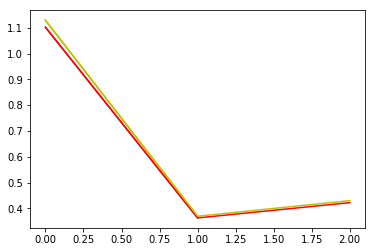

In [33]:
app = socketio.Middleware(sio, Flask(__name__))
eventlet.wsgi.server(eventlet.listen(('', 4567)), app, log_output=False)
#eventlet.wsgi.server(eventlet.listen(('', 4567)), app)

In [65]:
batch = drive.memory.batch(batch_size)


array([{'action': 151, 'advantage': array([98.84985], dtype=float32), 'id': 1, 'state': array([[[255, 255, 255],
        [255, 255, 255],
        [255, 255, 255],
        ...,
        [255, 255, 255],
        [255, 255, 255],
        [255, 255, 255]],

       [[255, 255, 255],
        [255, 255, 255],
        [255, 255, 255],
        ...,
        [255, 255, 255],
        [255, 255, 255],
        [255, 255, 255]],

       [[255, 255, 255],
        [255, 255, 255],
        [255, 255, 255],
        ...,
        [255, 255, 255],
        [255, 255, 255],
        [255, 255, 255]],

       ...,

       [[157, 124,  98],
        [157, 124,  98],
        [157, 124,  98],
        ...,
        [ 84,  92, 239],
        [ 84,  92, 239],
        [ 84,  92, 239]],

       [[157, 123,  99],
        [157, 123,  99],
        [157, 123,  99],
        ...,
        [ 84,  92, 239],
        [ 84,  92, 239],
        [ 84,  92, 239]],

       [[157, 123,  99],
        [157, 123,  99],
        [157, 123,  99],

In [37]:
img = drive.state
self = drive.ac_network
sess = self.sess
np.mean(sess.run(self.common, feed_dict={self.inputs: [img]}))

17.562746

In [ ]:
np.sum(drive.metrics['round_length']), len(drive.memory.d)

In [ ]:
#plt.plot(drive.speeds, 'g', drive.rewards, 'r')
plt.plot(drive.rewards, 'r')
plt.plot(drive.speeds, 'g')

In [ ]:
drive.plot_metrics()

In [ ]:
largest_angle = math.pi/9
angle, step_angle = 0, largest_angle/20.0
angles = [angle]

while angle < largest_angle:
    angle += step_angle
    angles.append(angle)
    angles.append(angle*-1)
print(sorted(angles))

In [ ]:
import pyautogui
for i in range(10):
    pyautogui.press('esc')
    #pyautogui.click()
    print(i)
    sleep(1)
    
    